In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import optuna
import shap
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\gucie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_timedelta_to_seconds(df):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.timedelta64):
            df[col] = df[col].dt.total_seconds()
    return df

In [3]:
# Load and prepare data
season_df = pd.read_pickle('season_full.pkl')
season_df = season_df.replace([np.inf, -np.inf], np.nan)
season_df = season_df.dropna()
season_df = convert_timedelta_to_seconds(season_df)

In [24]:
track_df = season_df.copy()
track_df['LapNumber'] = season_df.groupby(['Driver', 'Track'], sort=False).cumcount() + 1
track_df

,Track,Driver,Compound,TyreLife,StartFuel,FCL,LapTime,SpeedI1,SpeedI2,SpeedFL,SumLonAcc,SumLatAcc,MeanLapSpeed,LonDistanceDTW,LatDistanceDTW,LapNumber
0,Bahrain,VER,SOFT,4.0,100.000000,96.019000,99.019,232.0,231.0,278.0,561.07970,840.76762,185.815557,12.072970,16.422290,1
1,Bahrain,VER,SOFT,5.0,98.232143,95.000517,97.974,227.0,238.0,278.0,515.23100,855.49170,196.531157,11.740397,17.690049,2
2,Bahrain,VER,SOFT,7.0,94.696429,95.108589,97.976,228.0,238.0,278.0,512.35496,853.49005,197.711395,11.392580,17.845079,3
3,Bahrain,VER,SOFT,9.0,91.160714,95.224660,97.986,229.0,239.0,279.0,506.39443,798.17038,197.696016,11.075037,15.948652,4
4,Bahrain,VER,SOFT,10.0,89.392857,95.312696,98.021,230.0,239.0,279.0,503.46019,818.31458,197.638955,11.201066,16.233708,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19502,Abu Dhabi,MAG,HARD,31.0,9.684211,90.128421,90.445,290.0,305.0,207.0,467.16149,1002.95167,207.503026,10.856932,27.158910,40
19503,Abu Dhabi,MAG,HARD,32.0,7.947368,89.942526,90.207,288.0,298.0,208.0,478.42989,986.54518,209.047495,17.515440,23.604216,41
19504,Abu Dhabi,MAG,HARD,33.0,6.210526,90.039631,90.252,286.0,299.0,210.0,477.92455,1002.83513,210.261800,12.364026,21.478274,42
19505,Abu Dhabi,MAG,HARD,34.0,4.473684,90.268736,90.429,287.0,306.0,209.0,474.41930,1013.42592,212.143581,10.556453,20.259695,43


In [4]:
X = season_df[['Compound', 'TyreLife', 'StartFuel', 'SpeedI1', 'SpeedI2', 'SpeedFL', 
               'SumLonAcc', 'SumLatAcc', 'MeanLapSpeed', 'LonDistanceDTW', 'LatDistanceDTW']]
y = season_df['LapTime']

In [5]:
le = LabelEncoder()
X.loc[:, 'Compound'] = le.fit_transform(X['Compound'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1221)

In [7]:
# best optiuna trial results
best_keras_params = {
    'n_layers': 4,
    'n_units_0': 74,
    'activation_0': 'relu',
    'dropout_0': 0.15160741111403084,
    'n_units_1': 103,
    'activation_1': 'relu',
    'dropout_1': 0.1473666699274242,
    'n_units_2': 89,
    'activation_2': 'elu',
    'dropout_2': 0.16629294681073242,
    'n_units_3': 58,
    'activation_3': 'elu',
    'dropout_3': 0.10720748148002543,
    'learning_rate': 0.002970873265244016,
    'batch_size': 16
}

# Create a dummy study and set best_params
class DummyStudy:
    def __init__(self, best_params):
        self.best_params = best_params

study_keras = DummyStudy(best_keras_params)

In [8]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [9]:
print("\nOptimizing XGBoost...")
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50)

# Train best XGBoost model
best_xgb = XGBRegressor(**study_xgb.best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)

[I 2025-06-09 02:43:29,002] A new study created in memory with name: no-name-a41016d6-5e08-4c29-9e36-c4ab134bac5f



Optimizing XGBoost...


[I 2025-06-09 02:43:29,555] Trial 0 finished with value: 5.892814640505557 and parameters: {'max_depth': 5, 'learning_rate': 0.2406201165077886, 'n_estimators': 135, 'min_child_weight': 3, 'subsample': 0.8463873967820134, 'colsample_bytree': 0.7160497258008505, 'gamma': 1.032546268798768}. Best is trial 0 with value: 5.892814640505557.
[I 2025-06-09 02:43:29,863] Trial 1 finished with value: 4.704589246047997 and parameters: {'max_depth': 10, 'learning_rate': 0.19418785141610262, 'n_estimators': 60, 'min_child_weight': 4, 'subsample': 0.8427641128937868, 'colsample_bytree': 0.8870072892670797, 'gamma': 2.130364144738639}. Best is trial 1 with value: 4.704589246047997.
[I 2025-06-09 02:43:30,267] Trial 2 finished with value: 5.139953367594133 and parameters: {'max_depth': 7, 'learning_rate': 0.26815313033427574, 'n_estimators': 230, 'min_child_weight': 1, 'subsample': 0.8245262478148246, 'colsample_bytree': 0.6805992198779088, 'gamma': 2.043113045800853}. Best is trial 1 with value: 4.7

In [10]:
best_keras = Sequential()
n_layers = study_keras.best_params['n_layers']

best_keras.add(Dense(
    study_keras.best_params['n_units_0'],
    activation=study_keras.best_params['activation_0'],
    input_shape=(X_train.shape[1],)
))
best_keras.add(Dropout(study_keras.best_params['dropout_0']))

for i in range(1, n_layers):
    best_keras.add(Dense(
        study_keras.best_params[f'n_units_{i}'],
        activation=study_keras.best_params[f'activation_{i}']
    ))
    best_keras.add(Dropout(study_keras.best_params[f'dropout_{i}']))

best_keras.add(Dense(1))
best_keras.compile(optimizer=Adam(learning_rate=study_keras.best_params['learning_rate']), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_keras.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=study_keras.best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=0
)

y_pred_keras = best_keras.predict(X_test).flatten()

c:\Users\gucie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [11]:
print("\nModel Performances:")
print(f"XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb):.4f}")
print(f"XGBoost R2: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"Keras MSE: {mean_squared_error(y_test, y_pred_keras):.4f}")
print(f"Keras R2: {r2_score(y_test, y_pred_keras):.4f}")


Model Performances:
XGBoost MSE: 3.8662
XGBoost R2: 0.9790
Keras MSE: 9.3139
Keras R2: 0.9494


In [13]:
xgb_season_pred = best_xgb.predict(X_scaled)
keras_season_pred = best_keras.predict(X_scaled).flatten()

610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


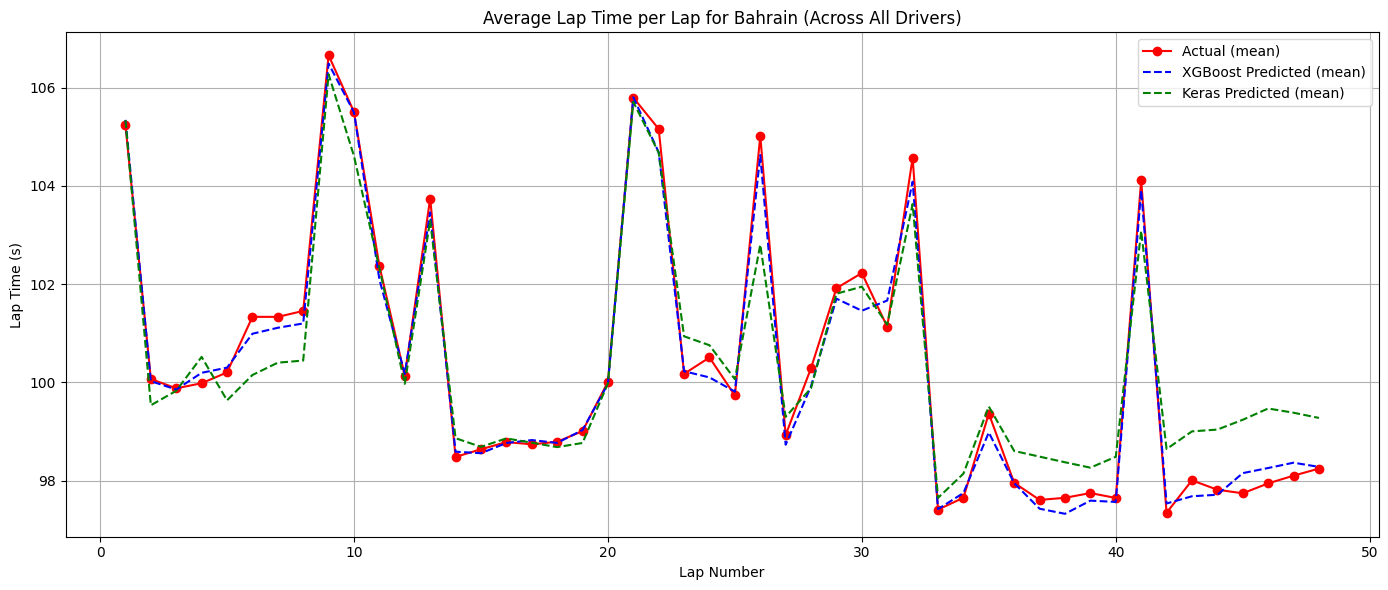

In [26]:
track_name = "Bahrain"  # Or any other track

# Filter the dataframe for the selected track
single_track_df = track_df[track_df['Track'] == track_name].copy()

# Add predictions if not already present
single_track_df['XGB_Pred'] = pd.Series(xgb_season_pred, index=season_df.index)[season_df['Track'] == track_name].reset_index(drop=True)
single_track_df['Keras_Pred'] = pd.Series(keras_season_pred, index=season_df.index)[season_df['Track'] == track_name].reset_index(drop=True)

# Group by LapNumber (averaging all drivers on that lap)
agg_df = single_track_df.groupby('LapNumber', as_index=False).agg({
    'LapTime': 'mean',
    'XGB_Pred': 'mean',
    'Keras_Pred': 'mean'
}).rename(columns={
    'LapTime': 'Actual',
    'XGB_Pred': 'Predicted_XGB',
    'Keras_Pred': 'Predicted_Keras'
})

# Optional: Remove outliers using IQR on Actual (to avoid bad laps like pit stops)
Q1 = agg_df['Actual'].quantile(0.25)
Q3 = agg_df['Actual'].quantile(0.75)
IQR = Q3 - Q1
mask = (agg_df['Actual'] >= Q1 - 1.5 * IQR) & (agg_df['Actual'] <= Q3 + 1.5 * IQR)
agg_clean = agg_df[mask]

# Plot mean lap times
plt.figure(figsize=(14, 6))
plt.plot(agg_clean['LapNumber'], agg_clean['Actual'], label='Actual (mean)', marker='o', color='red')
plt.plot(agg_clean['LapNumber'], agg_clean['Predicted_XGB'], label='XGBoost Predicted (mean)', linestyle='--', color='blue')
plt.plot(agg_clean['LapNumber'], agg_clean['Predicted_Keras'], label='Keras Predicted (mean)', linestyle='--', color='green')

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.title(f'Average Lap Time per Lap for {track_name} (Across All Drivers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


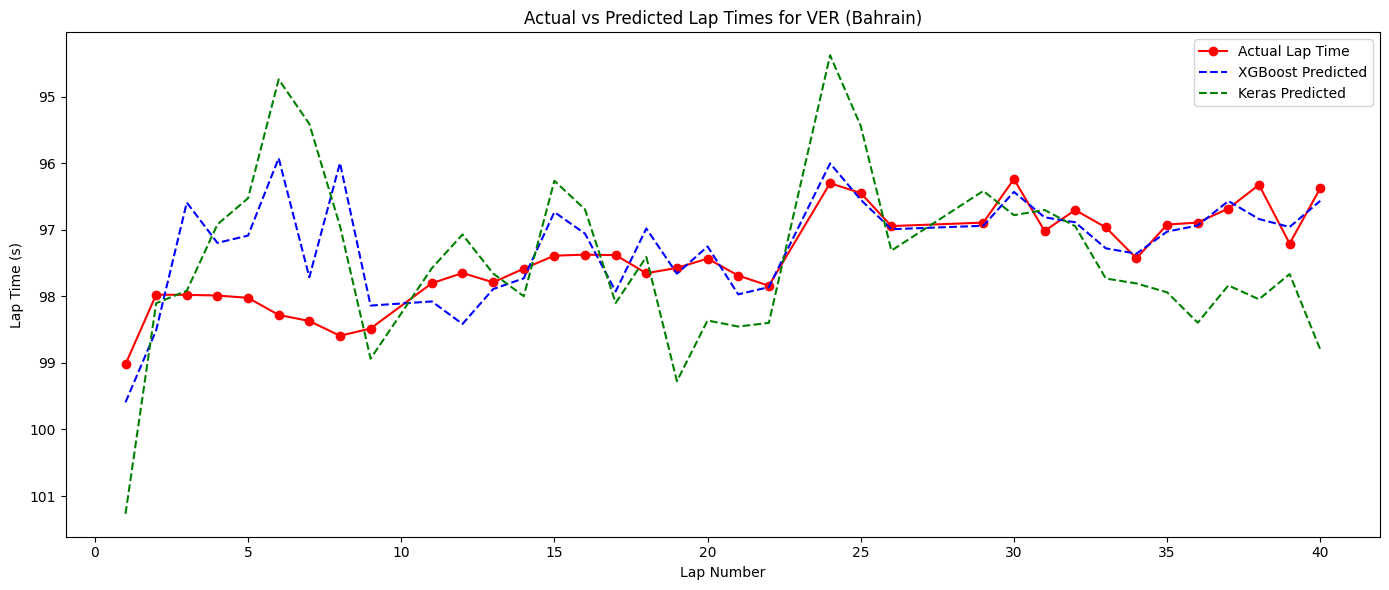

In [27]:
driver_name = 'VER' 


single_driver_df = track_df[(track_df['Track'] == track_name) & (track_df['Driver'] == driver_name)].copy()


single_driver_df['XGB_Pred'] = pd.Series(xgb_season_pred, index=season_df.index)[(season_df['Track'] == track_name) & (season_df['Driver'] == driver_name)].reset_index(drop=True)
single_driver_df['Keras_Pred'] = pd.Series(keras_season_pred, index=season_df.index)[(season_df['Track'] == track_name) & (season_df['Driver'] == driver_name)].reset_index(drop=True)

# tbh do funkcji jakiejs pewnie
Q1 = single_driver_df['LapTime'].quantile(0.25)
Q3 = single_driver_df['LapTime'].quantile(0.75)
IQR = Q3 - Q1
mask = (single_driver_df['LapTime'] >= Q1 - 1.5 * IQR) & (single_driver_df['LapTime'] <= Q3 + 1.5 * IQR)
driver_clean = single_driver_df[mask]

plt.figure(figsize=(14, 6))
plt.plot(driver_clean['LapNumber'], driver_clean['LapTime'], label='Actual Lap Time', marker='o', color='red')
plt.plot(driver_clean['LapNumber'], driver_clean['XGB_Pred'], label='XGBoost Predicted', linestyle='--', color='blue')
plt.plot(driver_clean['LapNumber'], driver_clean['Keras_Pred'], label='Keras Predicted', linestyle='--', color='green')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.title(f'Actual vs Predicted Lap Times for {driver_name} ({track_name})')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [28]:
track_metrics = []

for track in season_df['Track'].unique():
    mask = season_df['Track'] == track
    actual = season_df.loc[mask, 'LapTime'].reset_index(drop=True)
    xgb_pred = pd.Series(xgb_season_pred, index=season_df.index)[mask].reset_index(drop=True)
    keras_pred = pd.Series(keras_season_pred, index=season_df.index)[mask].reset_index(drop=True)
    valid_mask = actual.notna() & xgb_pred.notna() & keras_pred.notna()
    actual = actual[valid_mask]
    xgb_pred = xgb_pred[valid_mask]
    keras_pred = keras_pred[valid_mask]
    track_metrics.append({
        'Track': track,
        'XGB_MSE': mean_squared_error(actual, xgb_pred),
        'XGB_R2': r2_score(actual, xgb_pred),
        'Keras_MSE': mean_squared_error(actual, keras_pred),
        'Keras_R2': r2_score(actual, keras_pred)
    })

track_metrics_df = pd.DataFrame(track_metrics).sort_values('XGB_MSE', ascending=False)
print(track_metrics_df)

            Track   XGB_MSE    XGB_R2  Keras_MSE  Keras_R2
1    Saudi Arabia  2.499847  0.973009  16.971387  0.816760
12    Netherlands  2.499006  0.989231  12.403963  0.946546
15          Japan  2.416270  0.964566  11.858474  0.826099
5          Monaco  2.220293  0.974068   8.305196  0.903000
9   Great Britain  1.771599  0.992598  17.711143  0.925998
20      Las Vegas  1.756421  0.980047   7.430489  0.915590
2       Australia  1.651313  0.986308  12.198407  0.898852
14      Singapore  1.034201  0.983345   6.797863  0.890525
7          Canada  0.958685  0.994027   7.974574  0.950318
0         Bahrain  0.857617  0.982210   4.783414  0.900773
16          Qatar  0.772287  0.996279   8.639365  0.958376
10        Hungary  0.743379  0.953420   3.300841  0.793168
18         Mexico  0.612092  0.986648   8.926393  0.805279
6           Spain  0.590765  0.965297   4.165775  0.755295
8         Austria  0.536222  0.991048   3.644883  0.939150
11        Belgium  0.396304  0.969929  14.648503 -0.1115

In [ ]:
# Print per-track metrics sorted by each metric, rounded to 2 decimal places
print("\nSorted by XGB_MSE (descending):")
print(track_metrics_df.sort_values('XGB_MSE', ascending=False).round(2))

print("\nSorted by XGB_R2 (descending):")
print(track_metrics_df.sort_values('XGB_R2', ascending=False).round(2))

print("\nSorted by Keras_MSE (descending):")
print(track_metrics_df.sort_values('Keras_MSE', ascending=False).round(2))

print("\nSorted by Keras_R2 (descending):")
print(track_metrics_df.sort_values('Keras_R2', ascending=False).round(2))


Sorted by XGB_MSE (descending):
            Track   XGB_MSE    XGB_R2  Keras_MSE  Keras_R2
1    Saudi Arabia  2.499847  0.973009  16.971387  0.816760
12    Netherlands  2.499006  0.989231  12.403963  0.946546
15          Japan  2.416270  0.964566  11.858474  0.826099
5          Monaco  2.220293  0.974068   8.305196  0.903000
9   Great Britain  1.771599  0.992598  17.711143  0.925998
20      Las Vegas  1.756421  0.980047   7.430489  0.915590
2       Australia  1.651313  0.986308  12.198407  0.898852
14      Singapore  1.034201  0.983345   6.797863  0.890525
7          Canada  0.958685  0.994027   7.974574  0.950318
0         Bahrain  0.857617  0.982210   4.783414  0.900773
16          Qatar  0.772287  0.996279   8.639365  0.958376
10        Hungary  0.743379  0.953420   3.300841  0.793168
18         Mexico  0.612092  0.986648   8.926393  0.805279
6           Spain  0.590765  0.965297   4.165775  0.755295
8         Austria  0.536222  0.991048   3.644883  0.939150
11        Belgium  0.39

In [ ]:

# Plot prediction errors distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_test - y_pred_xgb, bins=100, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('XGBoost Error Distribution')

plt.subplot(1, 2, 2)
plt.hist(y_test - y_pred_keras, bins=100, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Keras Error Distribution')
plt.tight_layout()
plt.show()

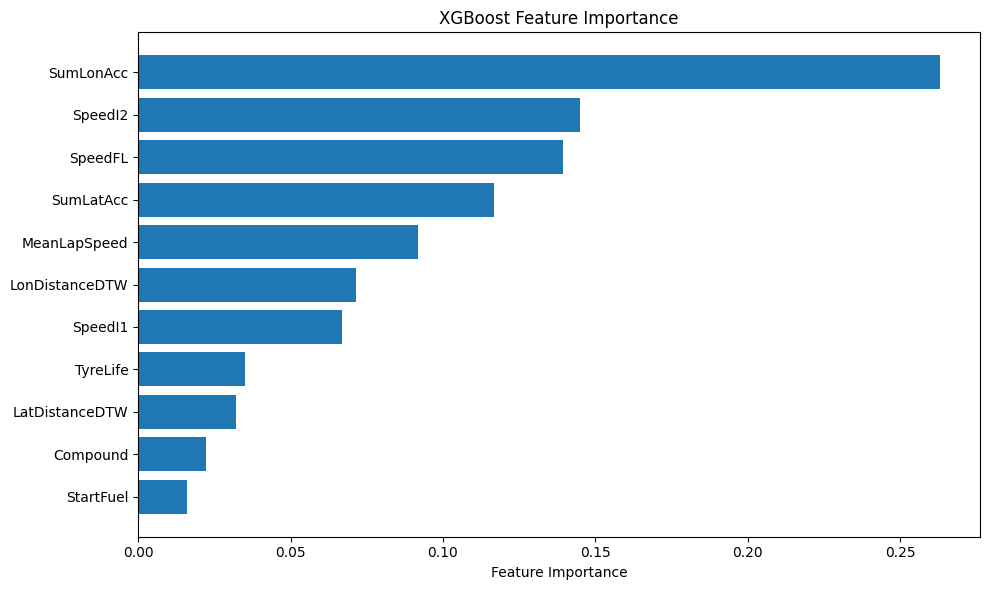

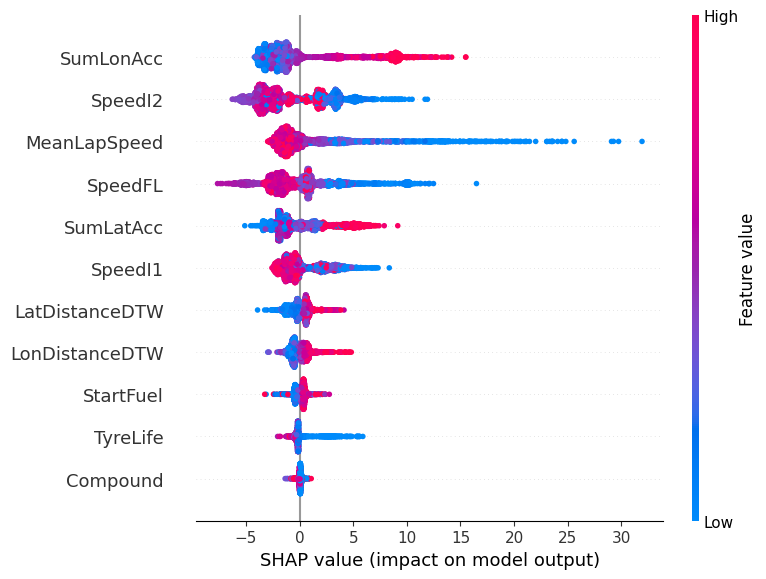

<Figure size 640x480 with 0 Axes>

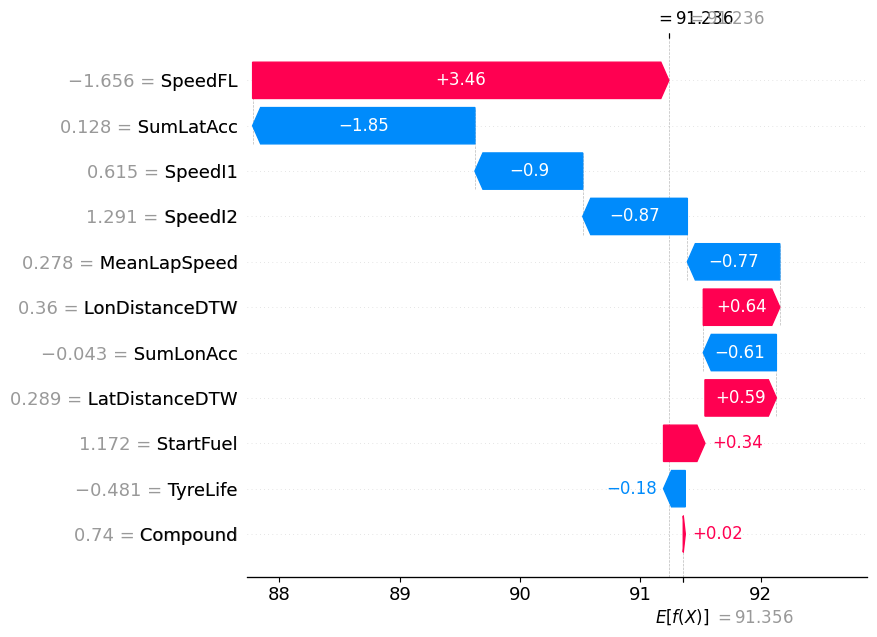

In [30]:
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# SHAP values for XGBoost
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.tight_layout()
plt.show()

explainer = shap.Explainer(best_xgb)  # use shap.Explainer for XGBoost models
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0], max_display=12)

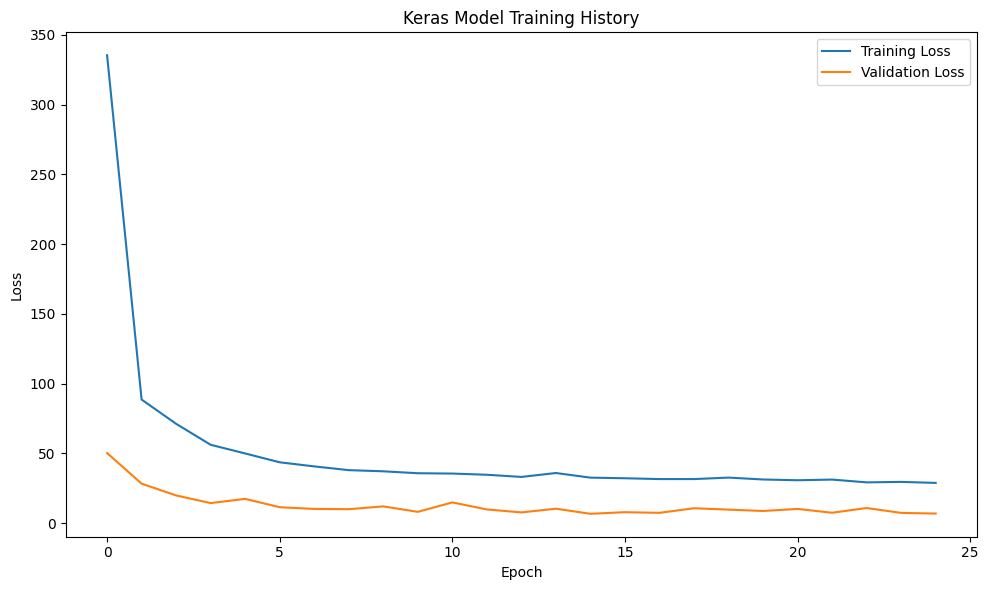

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Keras Model Training History')
plt.legend()
plt.tight_layout()
plt.show()

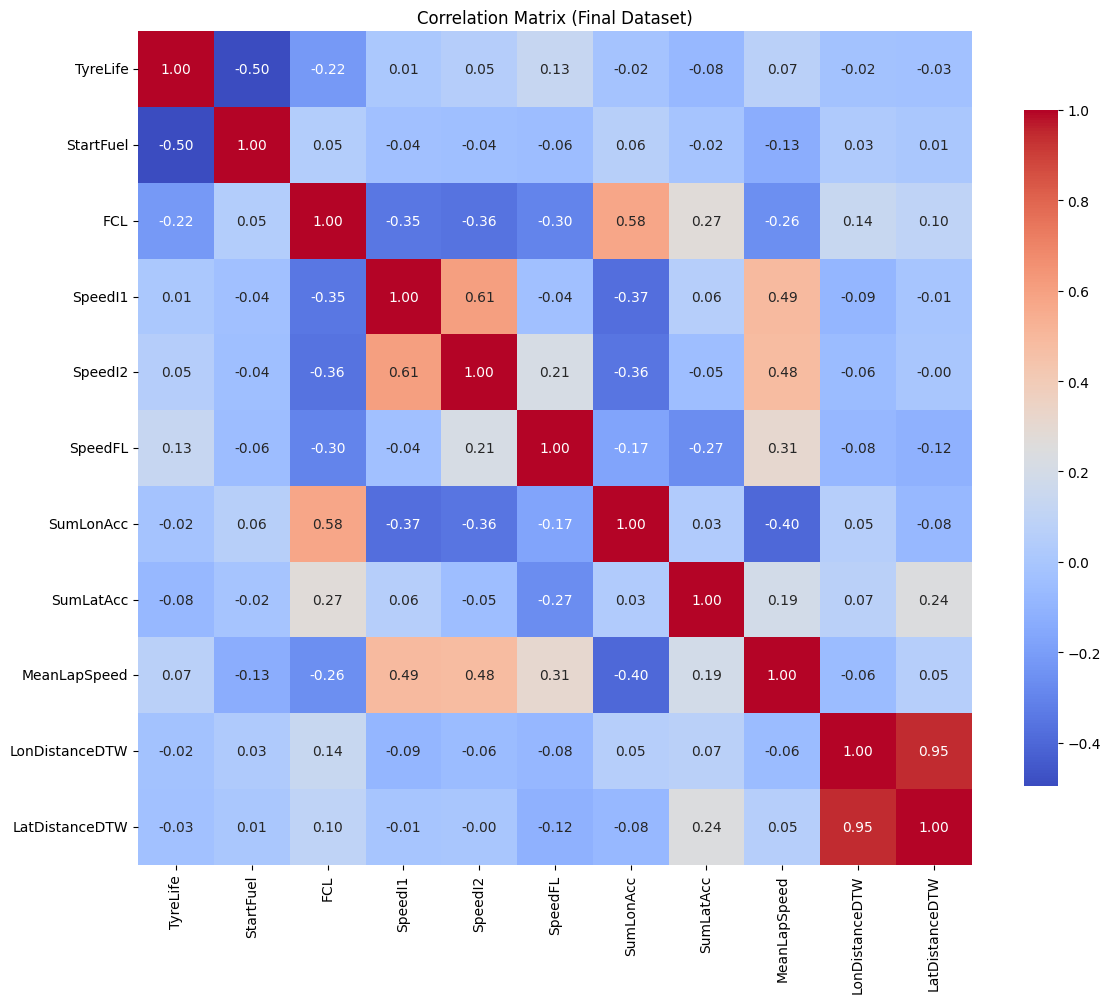

In [33]:
# Correlation plot for the season DataFrame (excluding 'LapTime')
plt.figure(figsize=(12, 10))
corr = season_df.drop(columns=['LapTime'], errors='ignore').corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix (Final Dataset)')
plt.tight_layout()
plt.show()